# Training Comparisons and Evaluations

##### Authors:
1. Ovidio Manteiga Moar
1. Carlos Villar Martínez

In this notebook the goal is to train a WGAN, this time the zdim will be twice the zdim used in the other wgan with colour images.

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, utils, metrics, optimizers
from Data_pre import prepare_data_generator_GAN

from utils import display

In [2]:
DATA_FOLDER = "./Dataset/img_align_celeba"

In [3]:
IMAGE_SIZE = 64
CHANNELS = 3

BATCH_SIZE = 64
NUM_FEATURES = 32
Z_DIM = 32

EPOCHS = 100
STEPS_PER_EPOCH=10

LEARNING_RATE = 0.0002
CRITIC_STEPS = 3

ADAM_BETA_1 = 0.5
ADAM_BETA_2 = 0.999

GP_WEIGHT = 10.0
LOAD_MODEL = False
ADAM_BETA_1 = 0.5
ADAM_BETA_2 = 0.9

#COLOR_MODE "rgb" or "graysacale"
COLOR_MODE = "rgb"

In [4]:
train = prepare_data_generator_GAN(DATA_FOLDER, IMAGE_SIZE, BATCH_SIZE, COLOR_MODE)

Found 202599 files belonging to 1 classes.


##### Building tthe WGAN-GP

In [5]:
critic_input = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))
x = layers.Conv2D(64, kernel_size=4, strides=2, padding="same")(critic_input)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2D(128, kernel_size=4, strides=2, padding="same")(x)
x = layers.LeakyReLU()(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(256, kernel_size=4, strides=2, padding="same")(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(512, kernel_size=4, strides=2, padding="same")(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(1, kernel_size=4, strides=1, padding="valid")(x)
critic_output = layers.Flatten()(x)

critic = models.Model(critic_input, critic_output)
critic.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 64)        3136      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       131200    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 dropout (Dropout)           (None, 16, 16, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 256)         524544

In [6]:
generator_input = layers.Input(shape=(Z_DIM,))
x = layers.Reshape((1, 1, Z_DIM))(generator_input)
x = layers.Conv2DTranspose(512, kernel_size=4, strides=1, padding="valid", use_bias=False)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same", use_bias=False)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same", use_bias=False)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2DTranspose(64, kernel_size=4, strides=2, padding="same", use_bias=False)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
generator_output = layers.Conv2DTranspose(CHANNELS, kernel_size=4, strides=2, padding="same", activation="tanh")(x)
generator = models.Model(generator_input, generator_output)
generator.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32)]              0         
                                                                 
 reshape (Reshape)           (None, 1, 1, 32)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 4, 4, 512)        262144    
 nspose)                                                         
                                                                 
 batch_normalization (BatchN  (None, 4, 4, 512)        2048      
 ormalization)                                                   
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 4, 4, 512)         0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 8, 8, 256)        2097

In [7]:
class WGANGP(models.Model):
    def __init__(self, critic, generator, latent_dim, critic_steps, gp_weight):
        super(WGANGP, self).__init__()
        self.critic = critic
        self.generator = generator
        self.latent_dim = latent_dim
        self.critic_steps = critic_steps
        self.gp_weight = gp_weight

    def compile(self, c_optimizer, g_optimizer):
        super(WGANGP, self).compile()
        self.c_optimizer = c_optimizer
        self.g_optimizer = g_optimizer
        self.c_wass_loss_metric = metrics.Mean(name="c_wass_loss")
        self.c_gp_metric = metrics.Mean(name="c_gp")
        self.c_loss_metric = metrics.Mean(name="c_loss")
        self.g_loss_metric = metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.c_loss_metric, self.c_wass_loss_metric, self.c_gp_metric, self.g_loss_metric]

    def gradient_penalty(self, batch_size, real_images, fake_images):
        alpha = tf.random.normal([batch_size, 1, 1, 1], 0.0, 1.0)
        diff = fake_images - real_images
        interpolated = real_images + alpha * diff

        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            pred = self.critic(interpolated, training=True)

        grads = gp_tape.gradient(pred, [interpolated])[0]
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp

    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]

        for i in range(self.critic_steps):
            random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

            with tf.GradientTape() as tape:
                fake_images = self.generator(random_latent_vectors, training=True)
                fake_predictions = self.critic(fake_images, training=True)
                real_predictions = self.critic(real_images, training=True)

                c_wass_loss = tf.reduce_mean(fake_predictions) - tf.reduce_mean(real_predictions)
                c_gp = self.gradient_penalty(batch_size, real_images, fake_images)
                c_loss = c_wass_loss + c_gp * self.gp_weight

            c_gradient = tape.gradient(c_loss, self.critic.trainable_variables)
            self.c_optimizer.apply_gradients(zip(c_gradient, self.critic.trainable_variables))

        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        with tf.GradientTape() as tape:
            fake_images = self.generator(random_latent_vectors, training=True)
            fake_predictions = self.critic(fake_images, training=True)
            g_loss = -tf.reduce_mean(fake_predictions)

        gen_gradient = tape.gradient(g_loss, self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(zip(gen_gradient, self.generator.trainable_variables))

        """
        self.c_loss_metric.update_state(c_loss)
        self.c_wass_loss_metric.update_state(c_wass_loss)
        self.c_gp_metric.update_state(c_gp)
        self.g_loss_metric.update_state(g_loss)

        return {m.name: m.result() for m in self.metrics}
        """
    
    
    
      # Calculate Critic and Generator Accuracy
        c_acc = tf.reduce_mean(tf.cast(tf.math.greater(real_predictions, 0), tf.float32)) * 100
        g_acc = tf.reduce_mean(tf.cast(tf.math.less(fake_predictions, 0), tf.float32)) * 100

        self.c_loss_metric.update_state(c_loss)
        self.c_wass_loss_metric.update_state(c_wass_loss)
        self.c_gp_metric.update_state(c_gp)
        self.g_loss_metric.update_state(g_loss)

        #return {m.name: m.result() for m in self.metrics,'c_acc': c_acc,'g_acc': g_acc}    
        return {**{m.name: m.result() for m in self.metrics}, 'c_acc': c_acc, 'g_acc': g_acc}

In [8]:
# Create a GAN
wgangp = WGANGP(critic=critic, generator=generator, latent_dim=Z_DIM, critic_steps=CRITIC_STEPS, gp_weight=GP_WEIGHT)

In [9]:
if LOAD_MODEL:
    wgangp.load_weights("./checkpoint/checkpoint.ckpt")

##### Training the GAN

In [10]:
# Compile the GAN
wgangp.compile(
    c_optimizer=optimizers.Adam(learning_rate=LEARNING_RATE, beta_1=ADAM_BETA_1, beta_2=ADAM_BETA_2),
    g_optimizer=optimizers.Adam(learning_rate=LEARNING_RATE, beta_1=ADAM_BETA_1, beta_2=ADAM_BETA_2),
)

In [11]:
# Create a model save checkpoint
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./checkpoint/checkpoint.ckpt",
    save_weights_only=True,
    save_freq="epoch",
    verbose=0,
)

tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")


real_images = np.array(list(train.unbatch().take(10).as_numpy_iterator()))
print(real_images.shape)
print(real_images[0].shape)
from fid import get_fid

class ImageGenerator(callbacks.Callback):
    def __init__(self, num_img, latent_dim):
        self.num_img = num_img
        self.latent_dim = latent_dim
        self.history = { 'fid': [] }

    def on_epoch_end(self, epoch, logs=None):
        if epoch % 50 != 0:
            return
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images = generated_images * 127.5 + 127.5
        generated_images = generated_images.numpy()
        display(generated_images, save_to="./output/generated_img_%03d.png" % (epoch), cmap=None)
        #fid = get_fid(real_images, generated_images)
        #self.history['fid'].append(fid)

(10, 64, 64, 3)
(64, 64, 3)


In [12]:
class LossHistory(callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.history = {
            'c_loss': [],
            'g_loss': [],
            'c_acc': [],
            'g_acc': [],
        }

    def on_epoch_end(self, epoch, logs=None):
        self.history['c_loss'].append(logs['c_loss'])
        self.history['g_loss'].append(logs['g_loss'])
        self.history['c_acc'].append(logs['c_acc'])
        self.history['g_acc'].append(logs['g_acc'])

loss_history = LossHistory()

Epoch 1/100
10/10 [==============================] - ETA: 0s - c_loss: -53.0598 - c_wass_loss: -73.9998 - c_gp: 2.0940 - g_loss: 5.2942 - c_acc: 100.0000 - g_acc: 76.5625 
Saved to ./output/generated_img_000.png


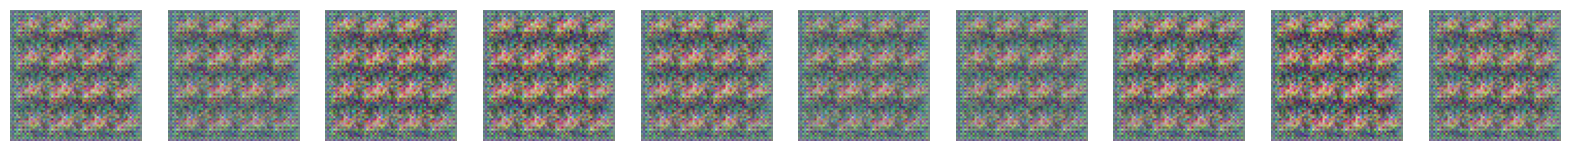

10/10 [==============================] - 114s 10s/step - c_loss: -53.0598 - c_wass_loss: -73.9998 - c_gp: 2.0940 - g_loss: 5.2942 - c_acc: 100.0000 - g_acc: 78.6932
Epoch 2/100
10/10 [==============================] - 88s 9s/step - c_loss: -102.7059 - c_wass_loss: -157.3784 - c_gp: 5.4672 - g_loss: 15.1817 - c_acc: 100.0000 - g_acc: 88.3523
Epoch 3/100
10/10 [==============================] - 92s 9s/step - c_loss: -81.8154 - c_wass_loss: -124.5769 - c_gp: 4.2762 - g_loss: 9.6459 - c_acc: 100.0000 - g_acc: 80.8239
Epoch 4/100
10/10 [==============================] - 81s 8s/step - c_loss: -71.1001 - c_wass_loss: -106.8915 - c_gp: 3.5791 - g_loss: 5.5832 - c_acc: 97.5852 - g_acc: 55.6818
Epoch 5/100
10/10 [==============================] - 78s 8s/step - c_loss: -32.6635 - c_wass_loss: -43.5674 - c_gp: 1.0904 - g_loss: -6.6883 - c_acc: 94.1761 - g_acc: 37.5000
Epoch 6/100
10/10 [==============================] - 96s 10s/step - c_loss: -15.2865 - c_wass_loss: -18.4301 - c_gp: 0.3144 - g_los

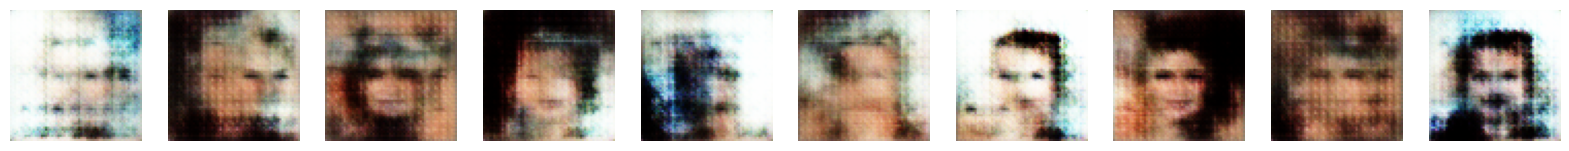

10/10 [==============================] - 89s 9s/step - c_loss: -7.8088 - c_wass_loss: -9.0440 - c_gp: 0.1235 - g_loss: -65.5207 - c_acc: 100.0000 - g_acc: 0.0000e+00
Epoch 52/100
10/10 [==============================] - 85s 8s/step - c_loss: -9.2273 - c_wass_loss: -10.6555 - c_gp: 0.1428 - g_loss: -60.3280 - c_acc: 99.7159 - g_acc: 1.4205
Epoch 53/100
10/10 [==============================] - 89s 9s/step - c_loss: -8.1305 - c_wass_loss: -9.2614 - c_gp: 0.1131 - g_loss: -64.8329 - c_acc: 99.8580 - g_acc: 0.1420
Epoch 54/100
10/10 [==============================] - 88s 9s/step - c_loss: -7.9942 - c_wass_loss: -9.0734 - c_gp: 0.1079 - g_loss: -57.2480 - c_acc: 100.0000 - g_acc: 0.7102
Epoch 55/100
10/10 [==============================] - 84s 8s/step - c_loss: -7.3539 - c_wass_loss: -8.2350 - c_gp: 0.0881 - g_loss: -50.8712 - c_acc: 99.8580 - g_acc: 0.0000e+00
Epoch 56/100
10/10 [==============================] - 7428s 824s/step - c_loss: -6.8038 - c_wass_loss: -7.8650 - c_gp: 0.1061 - g_lo

In [13]:
loss_history = LossHistory()

wgangp.fit(
    train,
    #train.take(1),
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    #steps_per_epoch=1,
    callbacks=[model_checkpoint_callback, tensorboard_callback, ImageGenerator(num_img=10, latent_dim=Z_DIM), loss_history],
)

In [14]:
# Save the model to explore latent space
# It doesn't work with subclassed models.

# tf.saved_model.save(wgangp, "models/wgangp")


##### Generate the images

1/1 [==============================] - 0s 369ms/step


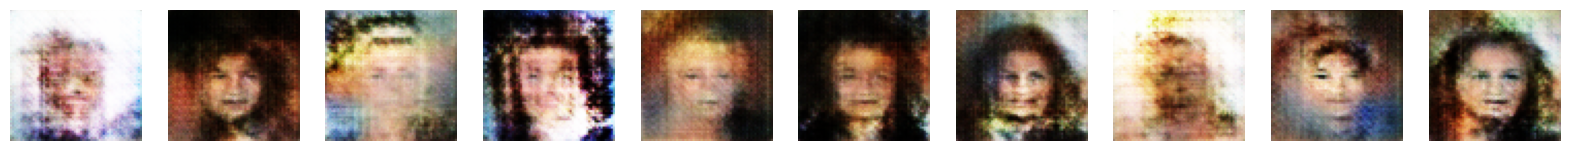

In [15]:
z_sample = np.random.normal(size=(10, Z_DIM))
imgs = wgangp.generator.predict(z_sample)
display(imgs, cmap=None)

Well, again we can see that the generated faces are not even close to be a real face.

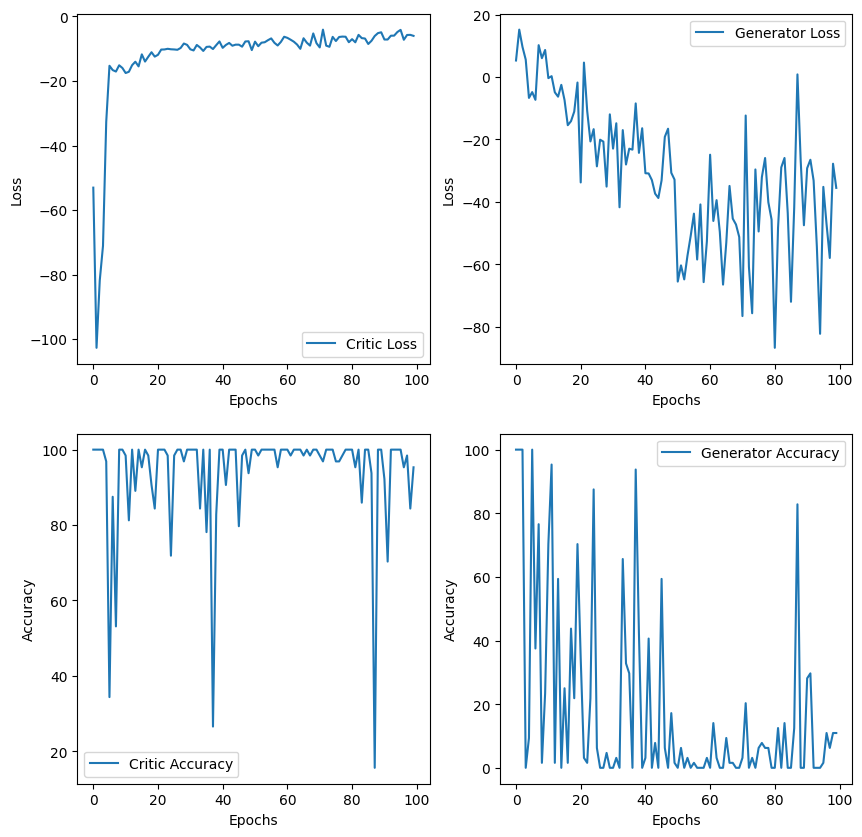

In [16]:
import matplotlib.pyplot as plt

def plot_losses_and_accuracy(loss_history):
    epochs = len(loss_history.history['c_loss'])
    x = range(epochs)

    fig, axs = plt.subplots(2, 2, figsize=(10, 10))
    
    axs[0, 0].plot(x, loss_history.history['c_loss'], label="Critic Loss")
    axs[0, 0].set(xlabel="Epochs", ylabel="Loss")
    axs[0, 0].legend()
    
    axs[0, 1].plot(x, loss_history.history['g_loss'], label="Generator Loss")
    axs[0, 1].set(xlabel="Epochs", ylabel="Loss")
    axs[0, 1].legend()
    
    axs[1, 0].plot(x, loss_history.history['c_acc'], label="Critic Accuracy")
    axs[1, 0].set(xlabel="Epochs", ylabel="Accuracy")
    axs[1, 0].legend()
    
    axs[1, 1].plot(x, loss_history.history['g_acc'], label="Generator Accuracy")
    axs[1, 1].set(xlabel="Epochs", ylabel="Accuracy")
    axs[1, 1].legend()

    plt.show()

plot_losses_and_accuracy(loss_history)